In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split as tts, cross_val_score as cv, RepeatedStratifiedKFold as rsk
from sklearn.ensemble import RandomForestClassifier as rf, ExtraTreesClassifier as et, BaggingClassifier as bc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.utils import class_weight
# import lightgbm as lgb

In [2]:
df_train = pd.read_csv("train_df_renamed.csv")
df_test = pd.read_csv("test_df_renamed.csv")

In [3]:
all_equal = df_train.groupby('Household level identifier')['Target'].apply(lambda x: x.nunique() == 1)
not_equal = all_equal[all_equal != True]
print('No of households where target values are not all the same: %s'%(len(not_equal)))

No of households where target values are not all the same: 70


In [4]:
# e.g. of households with different target values
df_train[df_train['Household level identifier'] == not_equal.index[0]][['Household level identifier', '=1 if household head', 'Target']]

,Household level identifier,=1 if household head,Target
6991,0172ab1d9,0,3
6992,0172ab1d9,0,2
6993,0172ab1d9,0,3
6994,0172ab1d9,1,3
6995,0172ab1d9,0,2


In [5]:
households_with_head = df_train.groupby('Household level identifier')['=1 if household head'].sum()
households_no_heads = df_train.loc[df_train['Household level identifier'].isin(households_with_head[households_with_head == 0].index), :]
print('No. of households with no heads: %s' %households_no_heads['Household level identifier'].nunique())

No. of households with no heads: 12


In [6]:
households_nh_equal = households_no_heads.groupby('Household level identifier')['Target'].apply(lambda x:x.nunique()==1)

In [7]:
print('No. of households with no heads & have different labels: %s' %sum(households_nh_equal==False))

No. of households with no heads & have different labels: 0


In [8]:
df_train.shape

(8608, 141)

In [9]:
# change households' targets with different target labels to be same as that household head
for h in not_equal.index:
    label = int(df_train[(df_train['Household level identifier'] == h) & (df_train['=1 if household head'] == 1)]['Target'])
    df_train.loc[df_train['Household level identifier'] == h, 'Target'] = label
    
all_equal_1 = df_train.groupby('Household level identifier')['Target'].apply(lambda x:x.nunique()==1)

In [10]:
a = df_train.groupby('Household level identifier')['Target'].apply(lambda x: x.nunique() == 1)
not_equal = a[a != True]
print('No of households where target values are not all the same: %s'%(len(not_equal)))

No of households where target values are not all the same: 0


In [11]:
#let's look at the distribution of the classes
target = df_train.values[:, -1]
counter = Counter(target)
for i, j in counter.items():
    percent = j/len(target)*100
    print('Class = %s, Count = %d, Percentage = %.3f%%' %(i, j, percent))

Class = 4, Count = 5593, Percentage = 64.974%
Class = 2, Count = 1288, Percentage = 14.963%
Class = 3, Count = 1085, Percentage = 12.605%
Class = 1, Count = 642, Percentage = 7.458%


So we see that not all the classes are equally distributed. This indicates that we may have to use means such as adding weights for multiclass classification for imbalanced dataset.

In [12]:
df_train.drop(df_train.loc[:, 'escolari squared':'Age squared'].columns,
                            axis = 1, inplace = True)
df_train.head()

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,=1 region Central,=1 region Chorotega,=1 region PacÃƒÂ­fico central,=1 region Brunca,=1 region Huetar AtlÃƒÂ¡ntica,=1 region Huetar Norte,=1 zona urbana,=2 zona rural,Age in years,Target
0,21eb7fcc1,ID_279628684,190000,0,3,0,1,1,0,0,...,1,0,0,0,0,0,1,0,43,4
1,0e5d7a658,ID_f29eb3ddd,135000,0,4,0,1,1,1,1,...,1,0,0,0,0,0,1,0,67,4
2,2c7317ea8,ID_68de51c94,0,0,8,0,1,1,0,0,...,1,0,0,0,0,0,1,0,92,4
3,2b58d945f,ID_d671db89c,180000,0,5,0,1,1,1,1,...,1,0,0,0,0,0,1,0,17,4
4,2b58d945f,ID_d56d6f5f5,180000,0,5,0,1,1,1,1,...,1,0,0,0,0,0,1,0,37,4


We don't actually need to include household level identifier and Id during training as they are actually irrelevant data. Therefore, we should drop them too.

In [13]:
df_train.drop(['Household level identifier', 'Id'], axis = 1,
             inplace = True)
df_train.head()

,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,Males younger than 12 years of age,Males 12 years of age and older,...,=1 region Central,=1 region Chorotega,=1 region PacÃƒÂ­fico central,=1 region Brunca,=1 region Huetar AtlÃƒÂ¡ntica,=1 region Huetar Norte,=1 zona urbana,=2 zona rural,Age in years,Target
0,190000,0,3,0,1,1,0,0,0,1,...,1,0,0,0,0,0,1,0,43,4
1,135000,0,4,0,1,1,1,1,0,1,...,1,0,0,0,0,0,1,0,67,4
2,0,0,8,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,92,4
3,180000,0,5,0,1,1,1,1,0,2,...,1,0,0,0,0,0,1,0,17,4
4,180000,0,5,0,1,1,1,1,0,2,...,1,0,0,0,0,0,1,0,37,4


## Functions for preprocessing data

In [14]:
#need to normalise some of the columns
def prepData(df):
    unnormal_cols = selectUnnormalised(df)
    x = df.iloc[:, :-1]
    y = df.iloc[:, -1:]
    xtrain, xtest, ytrain, ytest = tts(x,y,test_size = 0.3, random_state = 42)
    xTrain, xTest = normalise(unnormal_cols, xtrain, xtest)
    yTrain, yTest = ytrain.values.ravel(), ytest.values.ravel()
    return xTrain.values, xTest.values, yTrain, yTest

#getting the columns with non-normalised values
def selectUnnormalised(df):
    normCol = df.columns[df.isin([0,1]).all()] #getting the binary columns
    dfCols_list = list(df.columns)
    unnormCols = list(set(dfCols_list)-set(normCol))
    
    #remove target because we shouldn't normalise that, but rather encode
    unnormCols.remove('Target')
    return unnormCols

#normalising data in training set
def normalise(unnormCols, xTrain, xTest):
    #normalise training data
    toBeNorm_train = xTrain[[i for i in unnormCols]]
    ss = StandardScaler()
    std_scale = ss.fit(toBeNorm_train)
    xTrain_norm = std_scale.transform(toBeNorm_train)
    
    #covert numpy array to df
    xTrain_normCol = pd.DataFrame(xTrain_norm, index = toBeNorm_train.index,
                                 columns = toBeNorm_train.columns)
    xTrain.update(xTrain_normCol)
    
    #normalise test data using mean and SD of training set
    toBeNorm_test = xTest[[i for i in unnormCols]]
    xTest_norm = std_scale.transform(toBeNorm_test)
    xTest_normCol = pd.DataFrame(xTest_norm, index = toBeNorm_test.index,
                                columns = toBeNorm_test.columns)
    xTest.update(xTest_normCol)
    
    return xTrain, xTest



## Fuctions for training models

In [15]:
#training models
# we start with bagging classifier
def trainBG(xtrain, xtest, ytrain,  ytest):
    #get list of accuracies
    accEst_train = []
    accEst_test = []
    accFeat_train = []
    accFeat_test = []
    accSam_train = []
    accSam_test = []
    
    #to vary the parameters
    num_estimators = [500,800,1000,1250,1650]
    max_feature = [20,50,75,100,129]
    max_sample = [100,200,225,275,300]
    
    
    
    #train with varying num_estimators
    print("Training with varying num_estimators...")
    print("Completed run: \t")
    for i in range(0,len(num_estimators)):
       
        bc_clf = bc(n_estimators = num_estimators[i],
                   max_features = max_feature[0], max_samples = max_sample[0], n_jobs = 5)
        bc_clf.fit(xtrain, ytrain)
        accEst_train.append(bc_clf.score(xtrain, ytrain))
        accEst_test.append(bc_clf.score(xtest,ytest))
        print(str(i+1), end = "\t")
        
    best_est = num_estimators[np.argmax(accEst_test)]
    
    #train with varying max_features
    print("\nTraining with varying max_features...")
    print("Completed run: \t")
    for i in range(0,len(max_feature)):
        
        bc_clf = bc(n_estimators = best_est,
                   max_features = max_feature[i], max_samples = max_sample[0], n_jobs = 5)
        bc_clf.fit(xtrain, ytrain)
        accFeat_train.append(bc_clf.score(xtrain, ytrain))
        accFeat_test.append(bc_clf.score(xtest,ytest))
        print(str(i+1), end = "\t")
        
    best_numFeat = max_feature[np.argmax(accFeat_test)]
    
    #train with varying max_sample
    print("\nTraining with varying max_sample...")
    print("Completed run: \t")
    for i in range(0,len(max_sample)):
        
        bc_clf = bc(n_estimators = best_est,
                   max_features = best_numFeat, max_samples = max_sample[i], n_jobs = 5)
        bc_clf.fit(xtrain, ytrain)
        accSam_train.append(bc_clf.score(xtrain, ytrain))
        accSam_test.append(bc_clf.score(xtest,ytest))
        print(str(i+1), end = "\t")
        
    best_numSam = max_sample[np.argmax(accSam_test)]
    
    print("\n\nBest parameters for...\nnum_estimators: %d\tmax_features: %d\tmax_samples: %d" %(best_est, best_numFeat, best_numSam))
    
    return accEst_train, accEst_test, accFeat_train, accFeat_test, accSam_train, accSam_test

def trainRF_or_ET(modelName, xtrain, xtest, ytrain,  ytest):
    accEst_train = []
    accEst_test = []
    accDepth_train = []
    accDepth_test = []
    
    #to vary the parameters
    num_estimators = [500,800,1000,1250,1650]
    max_deep = [35,50,75,100,125]
    
    #train for varying num_estimators
    print("Training with varying num_estimators...")
    print("Completed run: \t")
    for i in range(0,len(num_estimators)):
        if(modelName == "random forest"):
            model = rf(n_estimators = num_estimators[i],
                       max_depth = max_deep[0], class_weight ='balanced')
            
        elif(modelName == "extra tree"):
            model = et(n_estimators = num_estimators[i],
                      max_depth = max_deep[0], class_weight = 'balanced')
        
        model.fit(xtrain,ytrain)
        accEst_train.append(model.score(xtrain, ytrain))
        accEst_test.append(model.score(xtest, ytest))
        print(str(i+1), end = "\t")
    
    best_est = num_estimators[np.argmax(accEst_test)]
    
    #train for varying max_depth
    print("\nTraining with varying max_depth...")
    print("Completed run: \t")
    for i in range(0,len(max_deep)):
        if(modelName == "random forest"):
            model = rf(n_estimators = best_est,
                       max_depth = max_deep[i], class_weight ='balanced')
            
        elif(modelName == "extra tree"):
            model = et(n_estimators = best_est,
                      max_depth = max_deep[i], class_weight = 'balanced')
        
        model.fit(xtrain,ytrain)
        accDepth_train.append(model.score(xtrain, ytrain))
        accDepth_test.append(model.score(xtest, ytest))
        print(str(i+1), end = "\t")
    
    best_depth = max_deep[np.argmax(accDepth_test)]
    
    print("\n\nBest parameters for...\nnum_estimators: %d\tmax_depth: %d" %(best_est, best_depth))

    return accEst_train, accEst_test, accDepth_train, accDepth_test

In [16]:
xTrain, xTest, yTrain, yTest = prepData(df_train)

In [17]:
estTrain_bg, estTest_bg, featureTrain_bg, featureTest_bg, sampleTrain_bg, sampleTest_bg= trainBG(xTrain, xTest, yTrain, yTest)

Training with varying num_estimators...
Completed run: 	
1	2	3	4	5	
Training with varying max_features...
Completed run: 	
1	2	3	4	5	
Training with varying max_sample...
Completed run: 	
1	2	3	4	5	

Best parameters for...
num_estimators: 500	max_features: 129	max_samples: 300


In [18]:
estTrain_rf, estTest_rf, depthTrain_rf, depthTest_rf = trainRF_or_ET("random forest", xTrain, xTest, yTrain, yTest)

Training with varying num_estimators...
Completed run: 	
1	2	3	4	5	
Training with varying max_depth...
Completed run: 	
1	2	3	4	5	

Best parameters for...
num_estimators: 500	max_depth: 100


In [19]:
estTrain_et, estTest_et, depthTrain_et, depthTest_et = trainRF_or_ET("extra tree", xTrain, xTest, yTrain, yTest)

Training with varying num_estimators...
Completed run: 	
1	2	3	4	5	
Training with varying max_depth...
Completed run: 	
1	2	3	4	5	

Best parameters for...
num_estimators: 500	max_depth: 35


## Plot graphs

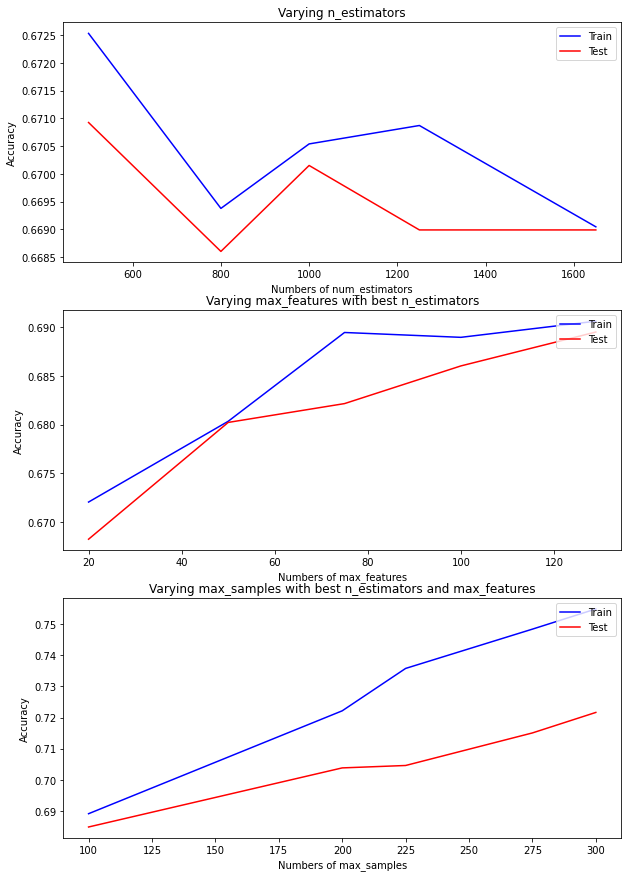

In [20]:
#plot graph for bagging classifier
title = ["Varying n_estimators", "Varying max_features with best n_estimators", "Varying max_samples with best n_estimators and max_features"]
fig, ax = plt.subplots(3,1, figsize = (10,15))

num_estimators = [500,800,1000,1250,1650]
max_feature = [20,50,75,100,129]
max_sample = [100,200,225,275,300]

ax[0].plot(num_estimators, estTrain_bg, "-b", label = "Train")
ax[0].plot(num_estimators, estTest_bg, "-r", label = "Test")
ax[0].legend(loc = "upper right")
ax[0].set_title(title[0])
ax[0].set_xlabel("Numbers of num_estimators")
ax[0].set_ylabel("Accuracy")

ax[1].plot(max_feature, featureTrain_bg, "-b", label = "Train")
ax[1].plot(max_feature, featureTest_bg, "-r", label = "Test")
ax[1].legend(loc = "upper right")
ax[1].set_title(title[1])
ax[1].set_xlabel("Numbers of max_features")
ax[1].set_ylabel("Accuracy")

ax[2].plot(max_sample, sampleTrain_bg, "-b", label = "Train")
ax[2].plot(max_sample, sampleTest_bg, "-r", label = "Test")
ax[2].legend(loc = "upper right")
ax[2].set_title(title[2])
ax[2].set_xlabel("Numbers of max_samples")
ax[2].set_ylabel("Accuracy")

plt.show()

From the graphs above, as we continue using the best parameters that give us the highest accuracy for test set, it is clear that the accuracy of the model rises. 

The optimal paramaters will be set as such:
- n_estimators = 500
- max_features = 129
- max_samples = 300

We shall take a look at the classification accuracy of the bagging classifier with the optimal parameters

In [21]:
bag = bc(n_estimators = 500, max_features = 129, max_samples = 300)
bag.fit(xTrain, yTrain)
y_pred = bag.predict(xTest)
print("Classification accuracy: {:.2f}".format(bag.score(xTest, yTest)))
print("F1 score: {:.2f}".format(f1_score(yTest, y_pred, average = 'macro')))

Classification accuracy: 0.72
F1 score: 0.43


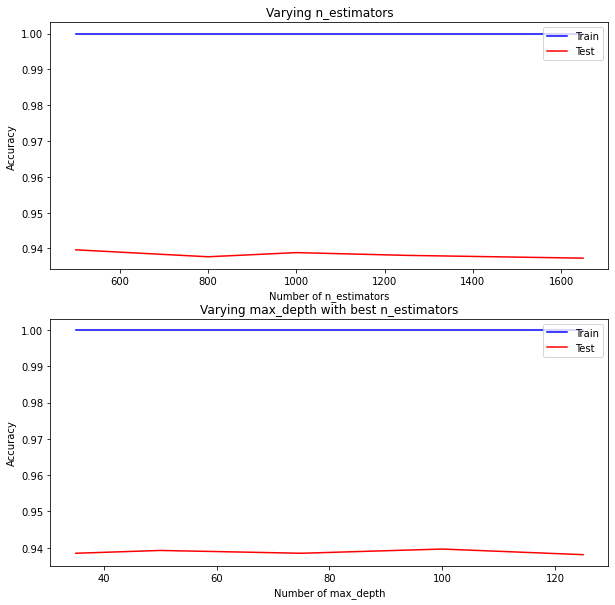

In [22]:
#plot graph for random forest
fig, ax = plt.subplots(2,1, figsize = (10,10))

title = ["Varying n_estimators", "Varying max_depth with best n_estimators"]

num_estimators = [500,800,1000,1250,1650]
max_deep = [35,50,75,100,125]

ax[0].plot(num_estimators, estTrain_rf, "-b", label = "Train")
ax[0].plot(num_estimators, estTest_rf, "-r", label = "Test")
ax[0].legend(loc = "upper right")
ax[0].set_title(title[0])
ax[0].set_xlabel("Number of n_estimators")
ax[0].set_ylabel("Accuracy")

ax[1].plot(max_deep, depthTrain_rf, "-b", label = "Train")
ax[1].plot(max_deep, depthTest_rf, "-r", label = "Test")
ax[1].legend(loc = "upper right")
ax[1].set_title(title[1])
ax[1].set_xlabel("Number of max_depth")
ax[1].set_ylabel("Accuracy")

plt.show()

Random forest classifier seems to perform much more accurately and the test accuracy is relatively consistent. Therefore, we shall follow the indicated optimal parameters and create a model using them. 

Optimal parameters:
- n_estimators = 500
- max_depth = 100
- class_weight = 'balanced'

Next, we shall assess the classification accuracy of the random forest classifier.

In [24]:
rff = rf(n_estimators = 500, max_depth = 100, class_weight = 'balanced')
rff.fit(xTrain, yTrain)
y_pred = rff.predict(xTest)
print("Classification accuracy: {:.2f}".format(rff.score(xTest, yTest)))
print("F1 score: {:.2f}".format(f1_score(yTest, y_pred, average = 'macro')))

Classification accuracy: 0.94
F1 score: 0.91


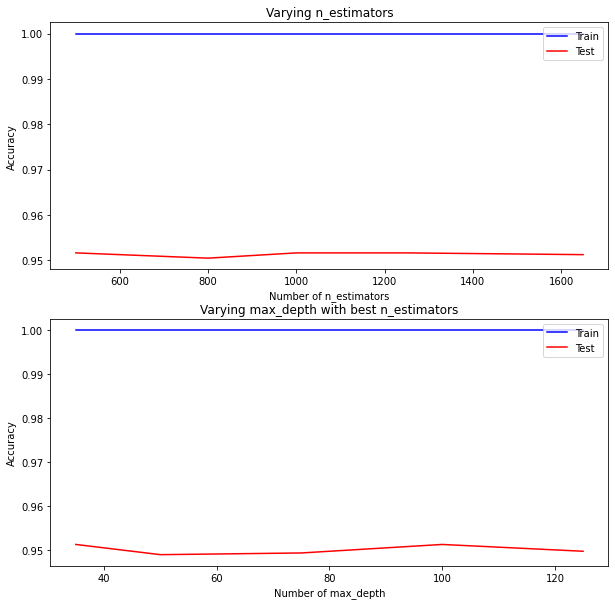

In [25]:
#plotting graph for extra trees
fig, ax = plt.subplots(2,1, figsize = (10,10))

title = ["Varying n_estimators", "Varying max_depth with best n_estimators"]

num_estimators = [500,800,1000,1250,1650]
max_deep = [35,50,75,100,125]

ax[0].plot(num_estimators, estTrain_et, "-b", label = "Train")
ax[0].plot(num_estimators, estTest_et, "-r", label = "Test")
ax[0].legend(loc = "upper right")
ax[0].set_title(title[0])
ax[0].set_xlabel("Number of n_estimators")
ax[0].set_ylabel("Accuracy")

ax[1].plot(max_deep, depthTrain_et, "-b", label = "Train")
ax[1].plot(max_deep, depthTest_et, "-r", label = "Test")
ax[1].legend(loc = "upper right")
ax[1].set_title(title[1])
ax[1].set_xlabel("Number of max_depth")
ax[1].set_ylabel("Accuracy")

plt.show()

It seems like extra trees is performing slightly better than random forest. As there are no indications of extreme overfitting and that the test accuracy is pretty consistent, we shall use the recommended optimal parameters and assess the accuracy score of the extra trees classifier model. 

Optimal parameters:
- n_estimators = 500
- max_depth = 35
- class_weight = 'balanced'

In [26]:
ett = et(n_estimators =500, max_depth = 35, class_weight = 'balanced')
ett.fit(xTrain, yTrain)
y_pred = ett.predict(xTest)
print("Classification accuracy: {:.2f}".format(ett.score(xTest, yTest)))
print("F1 score: {:.2f}".format(f1_score(yTest, y_pred, average = 'macro')))

Classification accuracy: 0.95
F1 score: 0.93


## Using LightGBM classifier

In [27]:
# build the model
lgb_clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.03, objective='multiclass',
                             random_state=None, silent=True, metric='multi_logloss', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.89, min_child_samples = 90, num_leaves = 56, subsample = 0.96)

# fit data into the model and predict the test set
lgb_clf.fit(xTrain, yTrain, eval_set=[(xTest, yTest)], 
            early_stopping_rounds=400, verbose=100)
y_pred = lgb_clf.predict(xTest)

Training until validation scores don't improve for 400 rounds
[100]	valid_0's multi_logloss: 0.593117
[200]	valid_0's multi_logloss: 0.387651
[300]	valid_0's multi_logloss: 0.28033
[400]	valid_0's multi_logloss: 0.222624
[500]	valid_0's multi_logloss: 0.193447
[600]	valid_0's multi_logloss: 0.178482
[700]	valid_0's multi_logloss: 0.174862
[800]	valid_0's multi_logloss: 0.177258
[900]	valid_0's multi_logloss: 0.183952
[1000]	valid_0's multi_logloss: 0.191155
Early stopping, best iteration is:
[689]	valid_0's multi_logloss: 0.17455


In [28]:
print("Classification accuracy: {:.2f}".format(lgb_clf.score(xTest, yTest)))
print("F1 score : {:.2f}".format(f1_score(yTest, y_pred, average = 'macro')))

Classification accuracy: 0.96
F1 score : 0.94


We conclude that **LightGBM** classifier model is the most suitable for classification of the poverty classes.

## Using only household heads

In [29]:
df_headsOnly = df_train[df_train['=1 if household head'] == 1]
df_headsOnly.head()

,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,Males younger than 12 years of age,Males 12 years of age and older,...,=1 region Central,=1 region Chorotega,=1 region PacÃƒÂ­fico central,=1 region Brunca,=1 region Huetar AtlÃƒÂ¡ntica,=1 region Huetar Norte,=1 zona urbana,=2 zona rural,Age in years,Target
0,190000,0,3,0,1,1,0,0,0,1,...,1,0,0,0,0,0,1,0,43,4
1,135000,0,4,0,1,1,1,1,0,1,...,1,0,0,0,0,0,1,0,67,4
2,0,0,8,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,92,4
5,180000,0,5,0,1,1,1,1,0,2,...,1,0,0,0,0,0,1,0,38,4
8,130000,1,2,0,1,1,0,0,0,1,...,1,0,0,0,0,0,1,0,30,4


In [30]:
xTrain, xTest, yTrain, yTest = prepData(df_headsOnly)

In [31]:
#Bagging classifier
estTrain_bg, estTest_bg, featureTrain_bg, featureTest_bg, sampleTrain_bg, sampleTest_bg= trainBG(xTrain, xTest, yTrain, yTest)

Training with varying num_estimators...
Completed run: 	
1	2	3	4	5	
Training with varying max_features...
Completed run: 	
1	2	3	4	5	
Training with varying max_sample...
Completed run: 	
1	2	3	4	5	

Best parameters for...
num_estimators: 1250	max_features: 129	max_samples: 200


In [32]:
#Random forest classifier
estTrain_rf, estTest_rf, depthTrain_rf, depthTest_rf = trainRF_or_ET("random forest", xTrain, xTest, yTrain, yTest)

Training with varying num_estimators...
Completed run: 	
1	2	3	4	5	
Training with varying max_depth...
Completed run: 	
1	2	3	4	5	

Best parameters for...
num_estimators: 500	max_depth: 50


In [33]:
#Extra trees classifier
estTrain_et, estTest_et, depthTrain_et, depthTest_et = trainRF_or_ET("extra tree", xTrain, xTest, yTrain, yTest)

Training with varying num_estimators...
Completed run: 	
1	2	3	4	5	
Training with varying max_depth...
Completed run: 	
1	2	3	4	5	

Best parameters for...
num_estimators: 800	max_depth: 75


Now we assess the models' performance...

In [34]:
bag_hh = bc(n_estimators = 1250, max_features = 129, max_samples = 200)
bag_hh.fit(xTrain, yTrain)
y_pred = bag_hh.predict(xTest)
print("Classification accuracy: {:.2f}".format(bag_hh.score(xTest, yTest)))
print("F1 score: {:.2f}".format(f1_score(yTest, y_pred, average = 'macro')))

Classification accuracy: 0.71
F1 score: 0.28


In [35]:
rff_hh = rf(n_estimators = 500, max_depth = 50, class_weight = 'balanced')
rff_hh.fit(xTrain, yTrain)
y_pred = rff_hh.predict(xTest)
print("Classification accuracy: {:.2f}".format(rff_hh.score(xTest, yTest)))
print("F1 score: {:.2f}".format(f1_score(yTest, y_pred, average = 'macro')))

Classification accuracy: 0.71
F1 score: 0.30


In [36]:
ett_hh = et(n_estimators =800, max_depth = 75, class_weight = 'balanced')
ett_hh.fit(xTrain, yTrain)
y_pred = ett_hh.predict(xTest)
print("Classification accuracy: {:.2f}".format(ett_hh.score(xTest, yTest)))
print("F1 score: {:.2f}".format(f1_score(yTest, y_pred, average = 'macro')))

Classification accuracy: 0.70
F1 score: 0.29


In [37]:
# build the model
lgb_hh = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.03, objective='multiclass',
                             random_state=None, silent=True, metric='multi_logloss', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.89, min_child_samples = 90, num_leaves = 56, subsample = 0.96)

# fit data into the model and predict the test set
lgb_hh.fit(xTrain, yTrain, eval_set=[(xTest, yTest)], 
            early_stopping_rounds=400, verbose=100)
y_pred = lgb_hh.predict(xTest)

Training until validation scores don't improve for 400 rounds
[100]	valid_0's multi_logloss: 1.01856
[200]	valid_0's multi_logloss: 0.994385
[300]	valid_0's multi_logloss: 0.982815
[400]	valid_0's multi_logloss: 0.980446
[500]	valid_0's multi_logloss: 0.982922
[600]	valid_0's multi_logloss: 0.999186
[700]	valid_0's multi_logloss: 1.01931
[800]	valid_0's multi_logloss: 1.04008
Early stopping, best iteration is:
[413]	valid_0's multi_logloss: 0.979539


In [38]:
print("Classification accuracy: {:.2f}".format(lgb_clf.score(xTest, yTest)))
print("F1 score : {:.2f}".format(f1_score(yTest, y_pred, average = 'macro')))

Classification accuracy: 0.93
F1 score : 0.37


Restricting the dataset to only using the household heads seems to result in a much lower accuracy score for the first 3 models. For LGBM, the accuracy was still high at 93%. However, the f1 score across all models were very poor. Hence, we shall train and test on the entire dataset instead.

## Predicting the test set

We will pass the test dataset into our best model and write a new csv which will consists of the following columns: <br>
1. Household id
2. Individual's ID
3. Predicted target/class

In [39]:
toTest_data = df_test.iloc[:, 2:131]
identity = df_test.iloc[:, 0:2]

In [40]:
#need to prepare special function to get normalised test set
#need to normalise some of the columns
def prepData2(df):
    unnormal_cols = selectUnnormalised2(df)
    x_df = normalise2(unnormal_cols, df)
    return x_df

#getting the columns with non-normalised values
def selectUnnormalised2(df):
    normCol = df.columns[df.isin([0,1]).all()] #getting the binary columns
    dfCols_list = list(df.columns)
    unnormCols = list(set(dfCols_list)-set(normCol))
    
    return unnormCols

#normalising data in training set
def normalise2(unnormCols, df):
    #normalise training data
    toBeNorm = df[[i for i in unnormCols]]
    ss = StandardScaler()
    std_scale = ss.fit(toBeNorm)
    x_norm = std_scale.transform(toBeNorm)
    
    #covert numpy array to df
    x_normCols = pd.DataFrame(x_norm, index = toBeNorm.index,
                                 columns = toBeNorm.columns)
    df.update(x_normCols)
    
    return df

In [41]:
xTest_true = prepData2(toTest_data) #generate normalised actual test set
xTest_true.head()

,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,Males younger than 12 years of age,Males 12 years of age and older,...,# of mobile phones,=1 region Central,=1 region Chorotega,=1 region PacÃƒÂ­fico central,=1 region Brunca,=1 region Huetar AtlÃƒÂ¡ntica,=1 region Huetar Norte,=1 zona urbana,=2 zona rural,Age in years
0,-0.448209,0,-0.031562,0,1,1,0,-0.498778,0.926417,-0.582620,...,-0.611722,1,0,0,0,0,0,1,0,-1.430048
1,-0.448209,0,-0.031562,0,1,1,0,-0.498778,0.926417,-0.582620,...,-0.611722,1,0,0,0,0,0,1,0,0.272029
2,-0.448209,0,-0.031562,0,1,1,0,-0.498778,0.926417,-0.582620,...,-0.611722,1,0,0,0,0,0,1,0,0.272029
3,-0.448209,0,5.872115,0,1,1,1,0.950721,-0.577824,-0.582620,...,-0.611722,1,0,0,0,0,0,1,0,1.100066
4,1.038290,0,-0.687526,0,1,1,1,0.950721,-0.577824,-1.601419,...,-1.304969,1,0,0,0,0,0,1,0,-0.786019


In [42]:
xTest_truePred = lgb_clf.predict(xTest_true)

In [43]:
identity['Predicted class'] = xTest_truePred
identity.head()

,Household level identifier,Id,Predicted class
0,72958b30c,ID_2f6873615,4
1,72958b30c,ID_1c78846d2,4
2,72958b30c,ID_e5442cf6a,4
3,5b598fbc9,ID_a8db26a79,4
4,1e2fc704e,ID_a62966799,4


In [44]:
#for submission
identity.to_csv('submission.csv')